<!-- # Gabor Filters and Filter Banks

Sources:
1. [Gabor Filters, Wikipedia](https://en.wikipedia.org/wiki/Gabor_filter)
2. [https://www.sciencedirect.com/topics/engineering/gabor-filter](https://www.sciencedirect.com/topics/engineering/gabor-filter)
3. [https://www.baeldung.com/cs/ml-gabor-filters](https://www.baeldung.com/cs/ml-gabor-filters)
4. [58 - What are Gabor filters?](https://www.youtube.com/watch?v=QEz4bG9P3Qs)
5. [https://inc.ucsd.edu/mplab/75/media//gabor.pdf](https://inc.ucsd.edu/mplab/75/media//gabor.pdf)
6. [https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97](https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97)
7. [Gabor filter banks for texture classification, scikit-image](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html)
8. [Gabor Filters, The University of Edinburgh](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/TRAPP1/filter.html)
9. [Tutorial 74 - What are Gabor filters and how to use them to generate features for machine learning?](https://www.youtube.com/watch?v=yn1NUwaxhZg) -->

# Filtros de Gabor e Bancos de Filtros
Por *João Victor Dell Agli Floriano*.

## Abstrato

Os Filtros de Gabor são um conjunto de filtros digitais propostos inicialmente por Dennis Gabor [1], um engenheiro-eletricista húngaro-britânico, para o caso 1D, e depois generalizados para o caso 2D por Gösta Granlund [2]. O conjunto dos filtros de Gabor é gerado pela multiplicação de duas funções, uma gaussiana, e uma senoidal, que a partir de um conjunto de parâmetros, gera um filtro que tem aplicação parecida com a de um laplaciano, resultando na identificação de bordas em sinais. Nesse artigo, é explorada sua geração e aplicação, testando-o para um conjunto de imagens, além de discutida sua importância para sua maior área de aplicação recente: a de inteligência artificial.

## Introdução

Propostos inicialmente por Dennis Gabor [1], um engenheiro-eletricista húngaro-britânico, para o caso 1D, e depois generalizados para o caso 2D por Gösta Granlund [2], os filtros de Gabor atualmente constituem uma importante ferramenta de processamento de imagens. Os filtros, gerados por um conjunto de 5 variáveis, são constituídos de uma senoide envelopada por uma gaussiana, e tem um efeito parecido com um filtro laplaciano, extraindo bordas de sinais. Essa extração se torna útil para caracterizar texturas, além de permitir a identificação de bordas de objetos, que de um ponto de vista macro, permitem a identificação de sua forma. 

Essas características tornam os Filtros de Gabor uma alternativa interessante de processamento de imagens, área que, em um mundo o qual o interesse por inteligência artificial tem crescido significativamente, tem ganhado ainda mais significância.

## Métodos

### Bibliotecas

Para o seguinte trabalho foram usadas três bibliotecas principais:
1. `numpy`
2. `matplotlib`
3. `imageio`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
import imageio.v3 as iio

### Funções Auxiliares

Também foram utilizadas três funções auxilires. A primeira, função `rerange()` realiza uma renormalização de um vetor para um desejado intervalo. A segunda `to_image()`, converte uma imagem para um formato mais próximo a de uma imagem, renormalizando-a no intervalo $[0, 255]$ e a convertendo para *uint8*. A terceira, `convert_to_grayscale()` converte uma imagem para preto e branco. 

In [2]:
def rerange(img : np.ndarray, 
            min = 0.0, 
            max = 1.0):
  """Function that converts an image to the given desired range.
  
  Parameters
  ----------

  img : np.ndarray
    Image to be normalized.
  min : float
    Bottom value of the new range for conversion.
  max : float
    Top value of the new range for conversion."""
  return ((img - np.min(img))/(np.max(img) - np.min(img)))*(max - min) + min

def to_image(img : np.ndarray):
  """Converts an image to the 8-bit unsigned integer range

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""
  
  return rerange(img, 0.0, 255.0).astype(np.uint8)

def convert_to_grayscale(img : np.ndarray):
  """Function that converts an image to grayscale with standard color weights.

  Parameters
  ----------

  img : np.ndarray
    Image to be converted."""
  shape = img.shape

  if shape[2] == 2:
    return to_image(img[:, :, 0])
  elif shape[2] == 3:
    return to_image(0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2])
  elif shape[2] == 4:
     return to_image(0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2])

### A Geração dos Filtros

O conjunto de Filtros de Gabor são gerados pela multiplicação de uma gaussiana por uma senoide:

$$g(x, y, \lambda, \theta, \psi, \sigma, \gamma) = exp(\frac{-x'^2 + \gamma^2 y'^2}{2\sigma^2}) \ exp(-i(2\pi \frac{x'}{\lambda} + \phi))$$

Com $x'$ e $y'$:

$$\begin{bmatrix}x' \\ y' \end{bmatrix} = 
\begin{bmatrix}
    cos(\theta) & sin(\theta) \\
    -sin(\theta) & cos(\theta)
\end{bmatrix} \cdot 
\begin{bmatrix}
x \\ y
\end{bmatrix}$$

Traduzindo a equação de geração dos filtros em código, obtém-se:

In [3]:
def gaussian_filter(shape : tuple, 
                    angle : float, 
                    sigma : float, 
                    gamma : float):
    """Returns a gaussian filter.
     
    Parameters
    ----------
    
    shape : tuple
      Size of the gaussian filter.
    angle : float
      Angle of the gaussian.
    sigma : float
      Standard deviation.
    gamma : float
      Aspect ratio of the gaussian. """
    x_l, y_l = shape

    gamma = gamma*x_l/y_l

    M = np.matrix([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
    
    x_ = np.linspace(-x_l/2, x_l/2, x_l)
    y_ = np.linspace(-y_l/2, y_l/2, y_l)

    x, y = np.meshgrid(x_, y_)

    R = np.asarray(M*np.matrix([np.ravel(x), np.ravel(y)]))

    x_r = R[0].reshape(x.shape)
    y_r = R[1].reshape(y.shape)
    
    g = np.exp(-0.5*(x_r**2 + (gamma*y_r)**2)/sigma**2)
    
    return rerange(g)

def sinusoidal_filter(shape : tuple, 
                      angle : float,
                      lamb : float, 
                      phi : float):
    """Returns a sinusoidal filter.
     
    Parameters
    ----------

    shape : tuple
      Size of the sinusoidal filter.
    angle : float
      Angle of the sinusoid.
    lamb : float
      Wavelength of the sinusoid.
    phi : float
      Phase of the sinusoid.

     """
   
    x_l, y_l = shape

    M = np.matrix([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
    
    x_ = np.linspace(-x_l/2, x_l/2, x_l)
    y_ = np.linspace(-y_l/2, y_l/2, y_l)

    x, y = np.meshgrid(x_, y_, )

    R = np.asarray(M*np.matrix([np.ravel(x), np.ravel(y)]))

    x_r = R[0].reshape(x.shape)
    y_r = R[1].reshape(y.shape)

    s = np.exp( -1j*( (2*np.pi/lamb)*(x_r) + phi ))

    return s

def gabor_filter(shape : tuple, 
                 angle : float, 
                 sigma : float, 
                 gamma : float,
                 lamb : float, 
                 phi : float):
  """Returns a gabor filter.
  
  Parameters
  ----------
  
  shape : tuple
    Size of the filter.
  angle : float
    Angle of the filter.
  sigma : float
    Standard deviation of the gaussian.
  gamma : float
    Aspect ratio of the gaussian. 
  lamb : float
      Wavelength of the sinusoid.
  phi : float
    Phase of the sinusoid.
  """
  return sinusoidal_filter(shape, angle, lamb, phi)*gaussian_filter(shape, angle, sigma, gamma)

def gabor_angle_set(shape : tuple, 
                    n_angles : int, 
                    sigma : float, 
                    gamma : float, 
                    lamb : float, 
                    phi : float) -> dict:
  """Returns a set of gabor filters varying in angle.
   
  Parameters
  ----------
   
  shape : tuple
    Size of the filters.
  n_angles : int
    Number of different angles.
  sigma : float
    Standard deviation of the gaussian.
  gamma : float
    Aspect ratio of the gaussian. 
  lamb : float
      Wavelength of the sinusoid.
  phi : float
    Phase of the sinusoid.
   """

  angles = np.linspace(0.0, 2*np.pi*(1 - 1/n_angles), n_angles)
  set_gabor = {}

  for angle in angles: 
    set_gabor[f"{360*angle/(2*np.pi):.2f}"] = gabor_filter(shape, angle, sigma, gamma, lamb, phi)
  
  return set_gabor 

É importante notar acima que a função que gera a parte gaussian foi renormalizada para o intervalo $[0.0, 1.0]$.

Definindo alguns parâmetros, consegue-se visualizar esse efeito multiplicativo:

- $\lambda = 4$
- $\phi = 0$
- $\sigma = 2$
- $\gamma = 0.5$

In [4]:
lamb = 4.0
phi = 0.0
sigma = 2.0
angle = 0.0
gamma = 0.5

shape = (50, 50)

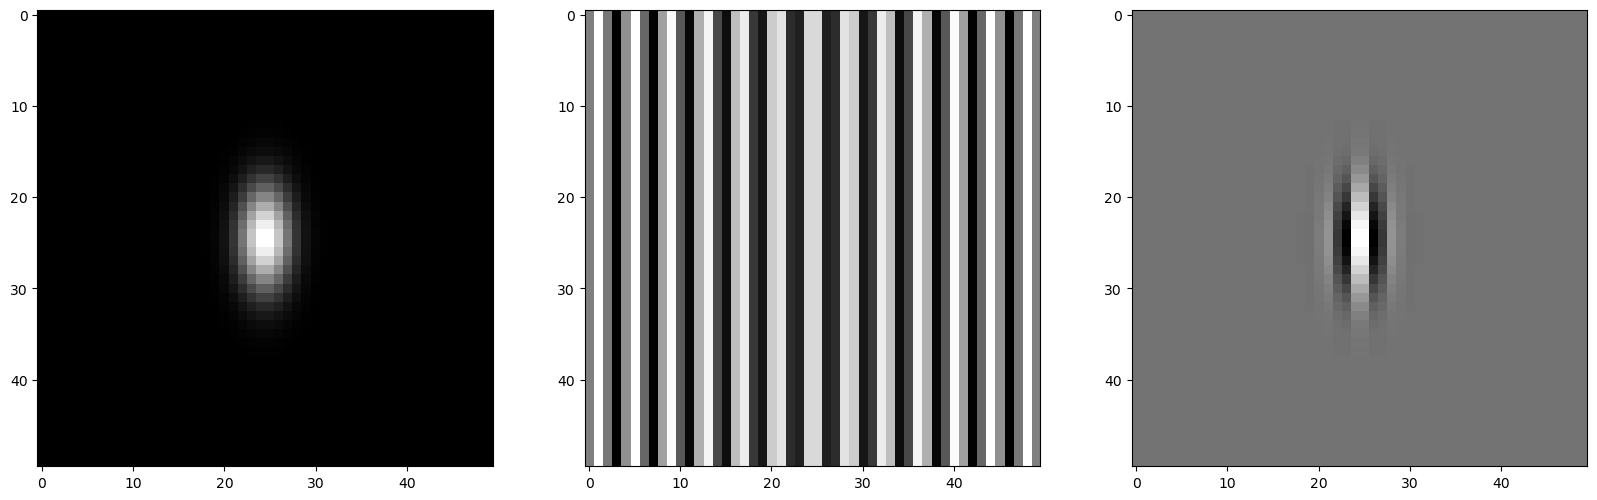

In [5]:
g = gaussian_filter(shape, angle, sigma, gamma)
s = sinusoidal_filter(shape, angle, lamb, phi)

gab = gabor_filter(shape, angle, sigma, gamma, lamb, phi)

plt.figure(figsize = (20, 20))

plt.subplot(131)
plt.imshow(g, cmap = "gray")

plt.subplot(132)
plt.imshow(s.real, cmap = "gray")

plt.subplot(133)
plt.imshow(gab.real, cmap = "gray")

Pode-se então, variar o ângulo. Para 9 ângulos diferentes, tem-se os seguintes filtros:

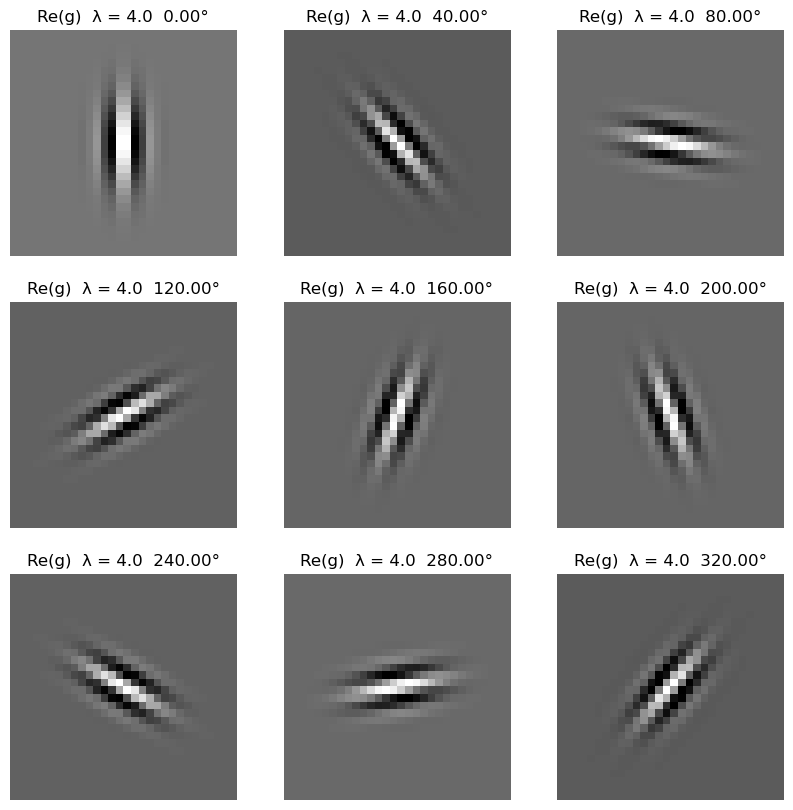

In [6]:
n_angles = 9
shape = (30, 30)
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
keys = np.array(list(gabor_set.keys()))
values = np.array(list(gabor_set.values()))

sub = 3*1e2 + 3*1e1 + 1*1e0

plt.figure(figsize = (10, 10))
for i in range(n_angles):
    plt.subplot(int(sub + i))
    plt.title("Re(g)  " + "λ = " + "{:.1f}".format(lamb) + "  " + keys[i] + "°")
    plt.imshow(values[i].real, cmap = "gray")
    plt.axis("off")
plt.show()

### Aplicação dos filtros

Obtidos os filtros, escolheu-se um conjunto de imagens para testar sua aplicação. 

TiffTag 338: 999 is not a valid TIFF.EXTRASAMPLE
TiffTag 338: 999 is not a valid TIFF.EXTRASAMPLE
TiffTag 338: 999 is not a valid TIFF.EXTRASAMPLE


(-0.5, 511.5, 511.5, -0.5)

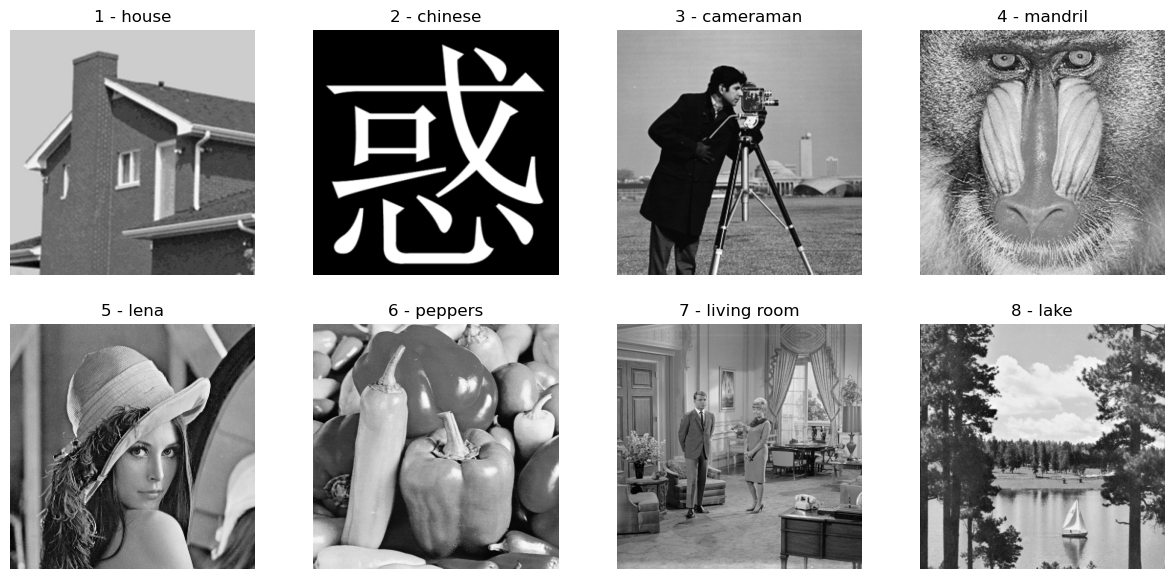

In [7]:
house = iio.imread("samples/house.tif")
chinese = iio.imread("samples/chinese.png")
chinese = convert_to_grayscale(chinese)[:330, :330]
cameraman = iio.imread("samples/cameraman.tif")
mandril = iio.imread("samples/mandril_gray.tif")
lena = iio.imread("samples/lena_gray_256.tif")
peppers = iio.imread("samples/peppers_gray.tif")
lroom = iio.imread("samples/livingroom.tif")
lake = iio.imread("samples/lake.tif")

house = convert_to_grayscale(house)
peppers = convert_to_grayscale(peppers)
lake = convert_to_grayscale(lake)

plt.figure(figsize=(15, 7))
plt.subplot(241)
plt.title("1 - house")
plt.imshow(house, cmap = "gray")
plt.axis("off")

plt.subplot(242)
plt.title("2 - chinese")
plt.imshow(chinese, cmap = "gray")
plt.axis("off")

plt.subplot(243)
plt.title("3 - cameraman")
plt.imshow(cameraman, cmap = "gray")
plt.axis("off")

plt.subplot(244)
plt.title("4 - mandril")
plt.imshow(mandril, cmap = "gray")
plt.axis("off")

plt.subplot(245)
plt.title("5 - lena")
plt.imshow(lena, cmap = "gray")
plt.axis("off")

plt.subplot(246)
plt.title("6 - peppers")
plt.imshow(peppers, cmap = "gray")
plt.axis("off")

plt.subplot(247)
plt.title("7 - living room")
plt.imshow(lroom, cmap = "gray")
plt.axis("off")

plt.subplot(248)
plt.title("8 - lake")
plt.imshow(lake, cmap = "gray")
plt.axis("off")


Para aplicação do filtro, o caminho tradicional é se convolver o filtro desejado com a imagem alvo, com o tradicional algoritmo de convolução, a qual cada pixel da nova imagem é uma soma ponderada dos pixels ao redor, incluindo aquele pixel, na mesma localização da imagem original, o qual os pesos são os valores do filtro na posição relativa à sua janela de aplicação.

$$ Conv(I, F, x, y) = \sum_{i = -d} ^d \sum_{j = -d} ^d F(d + i, d + j) I(x + i, y + j) $$

Que também tem a notação:

$$Conv(I, F) = F * I$$



Pretendia-se usar o caminho tradicional, porém optou-se por um caminho "alternativo", mais rápido, a partir da Transformada de Fourier. O Teorema da Convolução [3] descreve que, de maneira geral, a transformada de fourier de uma convolução entre duas variáveis é equivalente a uma simples multiplicação entre a transformada de fourier individual de cada uma.

$$\mathcal{F}(f*g) = \mathcal{F}(f) \cdot \mathcal{F}(g)$$

O que também significa que, caso se queira "simplificar" uma operação de convolução, basta realizar a transformada de fourier individual do filtro e da imagem alvo, realizar a sua multiplicação, e retornar ao espaço usual por meio de uma transformada inversa de fourier:

1. $$C = \mathcal{F}(F) \cdot \mathcal{F}(I)$$
2. $$\mathcal{F}^{-1}(C) = F*I$$

Para se aplicar o filtro na imagem alvo, então, foi implementada uma função que realiza essa operação, além de uma função que aplica uma série de filtros para que o processo seja facilitado.

In [8]:
def apply_filter(img : np.ndarray, filter : np.ndarray) -> np.ndarray: 
  """Convolves a filter with an image by the convolution theorem.
  
  Parameters
  ----------

  img : np.ndarray (N, M)
    Target image. 
  filter : np.ndarray (N, M)
    Filter to be applied. It must have the same size of the target image.
  """ 

  assert img.shape == filter.shape, "Image and filter must have the same size."

  img_fft = fft2(img)

  filter_fft = fft2(fftshift(filter))

  new_img_fft = filter_fft*img_fft

  new_img = ifft2(new_img_fft)

  return new_img

def apply_filter_set(img : np.ndarray, filter_set : dict) -> np.ndarray:
    """Convolves a set of filters with an image by the convolution theorem.
    
    Parameters
    ----------

    img : np.ndarray (N, M)
      Target image. 
    filter_set : np.ndarray (K, )
      Filter set to be applied. Each filter must have the same size of the target image."""
    values = np.array(list(filter_set.values()), copy=True)

    n_angles = values.shape[0]
    features = []

    for i in range(n_angles):
        
      filtered = apply_filter(img, values[i])
      filtered = rerange(filtered.real) + rerange(filtered.imag)*1j 
      features.append(filtered)

    return np.array(features)

Por último, foi definida uma função para também facilitar o processo de visualização dos resultados.

In [9]:
def show_filtered(filtered_set : np.ndarray, filter_set_keys : dict.keys, imag : bool = False, comparison : bool = False, original_img : np.ndarray = None, img_size : float = 3):
    """Plots a set of filtered images.
    
    Parameters
    ----------
    
    filtered_set : np.ndarray (M, )
        Set of filtered images.
    filter_set_keys : dict.keys
        Keys with the informations about each set element.
    imag : bool
        Whether it is desired to plot the imaginary part or not. 
        Default is False, which means the real part will be plotted.
    comparison : bool
        Whether it is desired to plot the comparison between the original 
        image and the sum of the filtered set. Default is False. If True, 
        the original image must be given by the original_img variable.
    original_img : np.ndarray
        Original image toe be plotted.  
    img_size : float
        Size fo the images to be plotted.
    """

    n_angles = filtered_set.shape[0]
    keys = np.array(list(filter_set_keys))

    l1 = np.floor(np.sqrt(n_angles))
    l2 = np.ceil(n_angles / l1)
    
    if comparison == False:

        sub = l1*100 + l2*10 + 1

        plt.figure(figsize = (l2*img_size, l1*img_size))
        for i in range(n_angles):
            plt.subplot(int(sub + i))
            plt.title("Re(g) "*(imag == False) + "Im(g) "*(imag == True) + keys[i] + "°")
            plt.imshow(filtered_set[i].real if imag == False else filtered_set[i].imag, cmap = "gray")
            plt.axis("off")
        plt.show()


    else:
        sum = np.zeros_like(filtered_set)

        sum = rerange(np.sum(filtered_set.real if imag == False else filtered_set.imag, axis = 0)/n_angles)

        plt.figure(figsize = (l1*img_size, l1*img_size))
        plt.subplot(121)
        plt.title("Original")
        plt.imshow(original_img, cmap = "gray")
        plt.axis("off")

        plt.subplot(122)
        plt.title("Summed results")
        plt.imshow(sum, cmap = "gray")
        plt.axis("off")
        plt.show()

## Resultados e Discussão

Com os métodos descritos, aplicou-se então um conjunto de filtros de 9 âgulos diferentes, inicialmente para os seguintes parâmetros:

In [10]:
lamb = 4.0
phi = 0.0
sigma = 2.0
angle = 0.0
gamma = 0.5

Para o conjunto de imagens descrito anteriormente.

### House

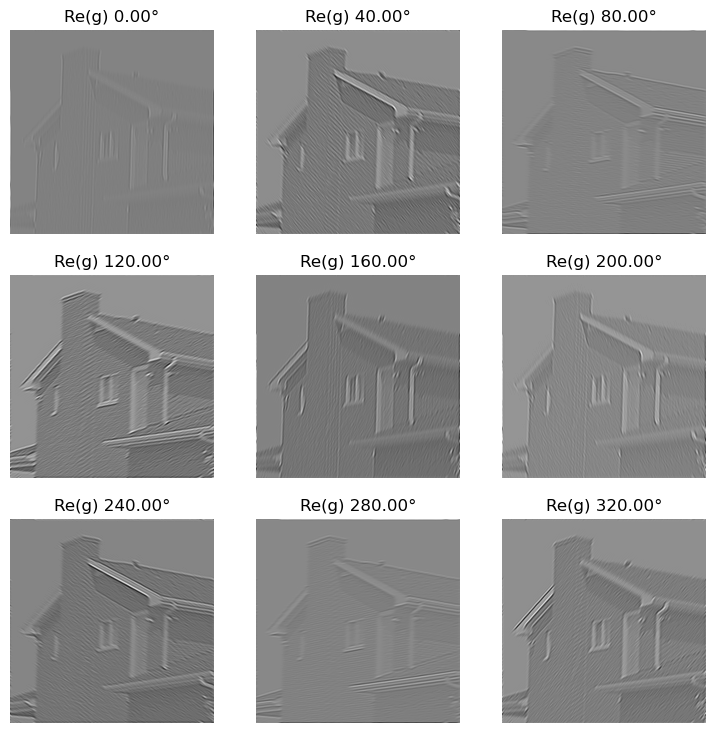

In [11]:
n_angles = 9
image = house
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Chinese

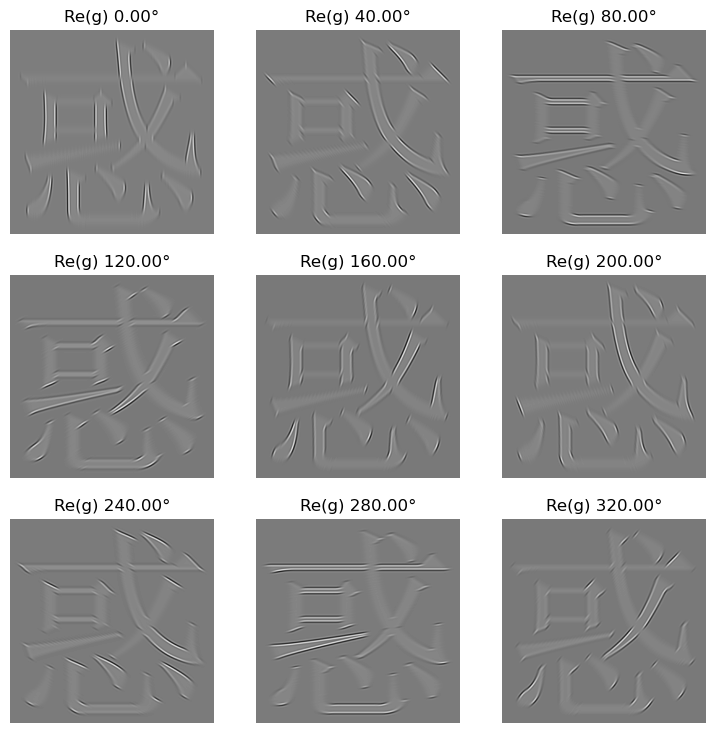

In [12]:
n_angles = 9
image = chinese
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Cameraman

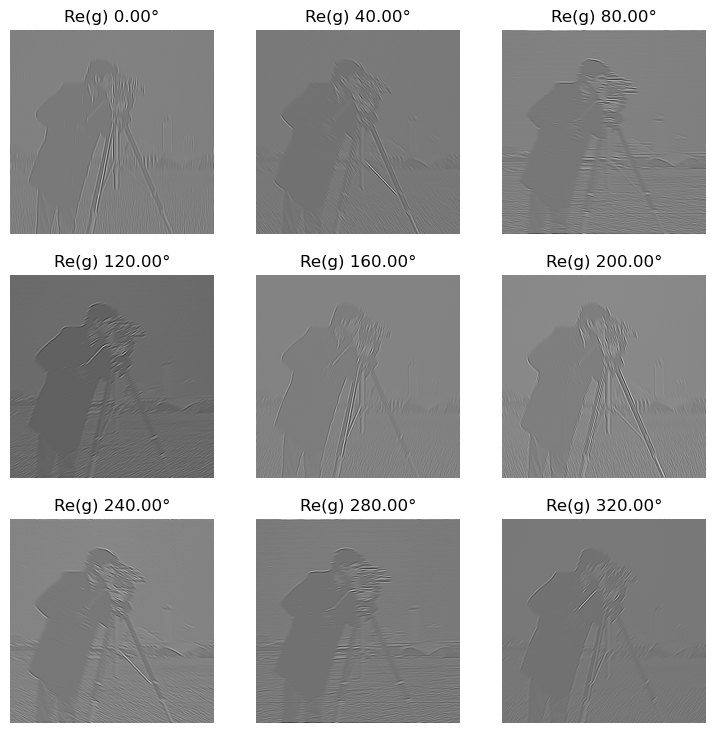

In [13]:
n_angles = 9
image = cameraman
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Mandril

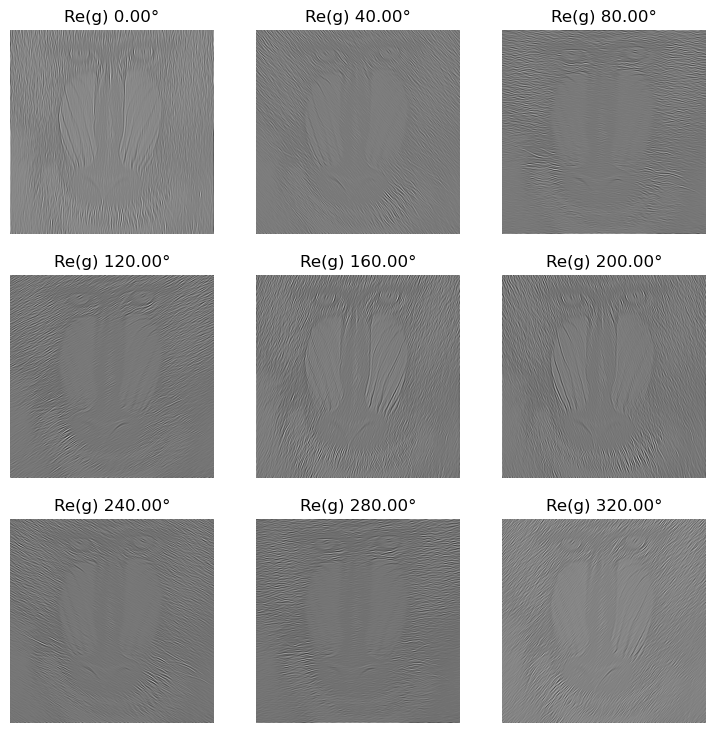

In [14]:
n_angles = 9
image = mandril
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Lena

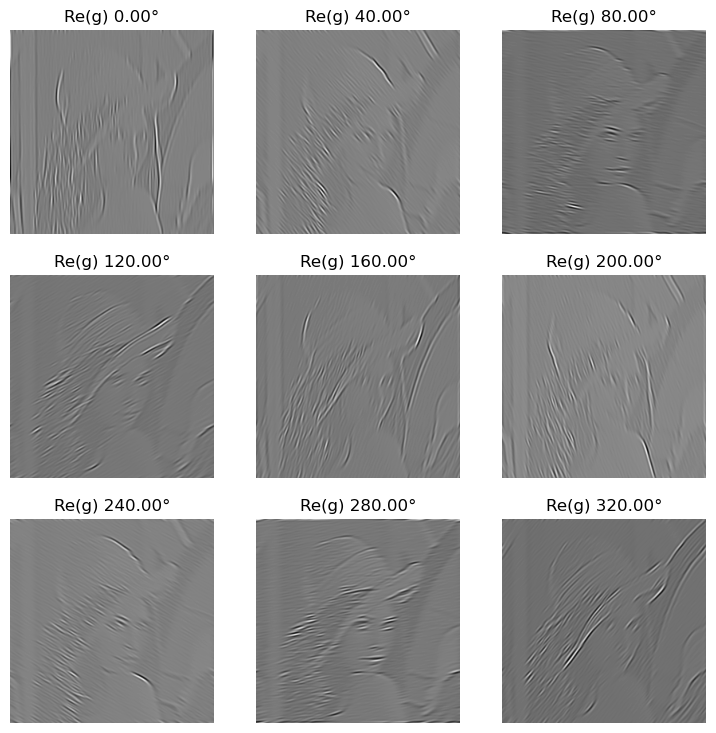

In [15]:
n_angles = 9
image = lena
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Peppers

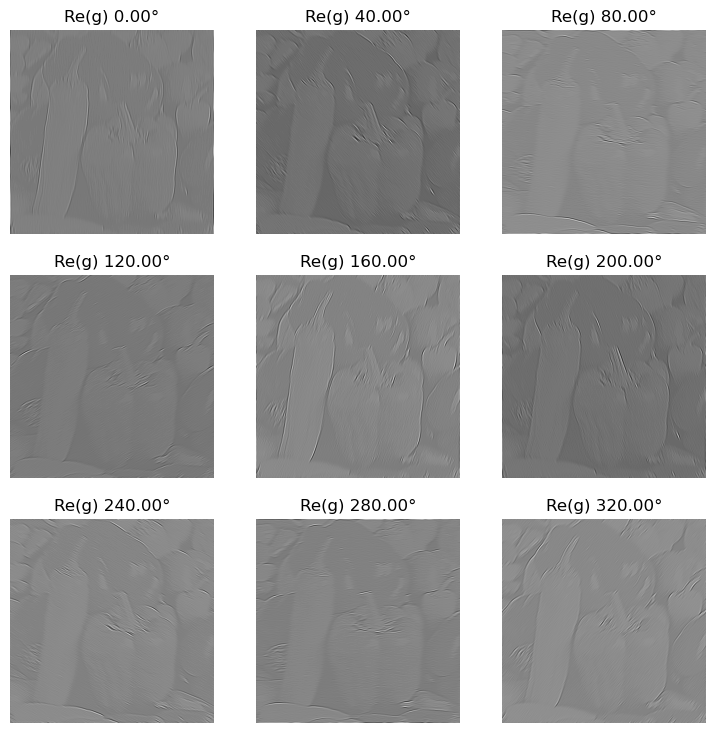

In [16]:
n_angles = 9
image = peppers
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Living Room

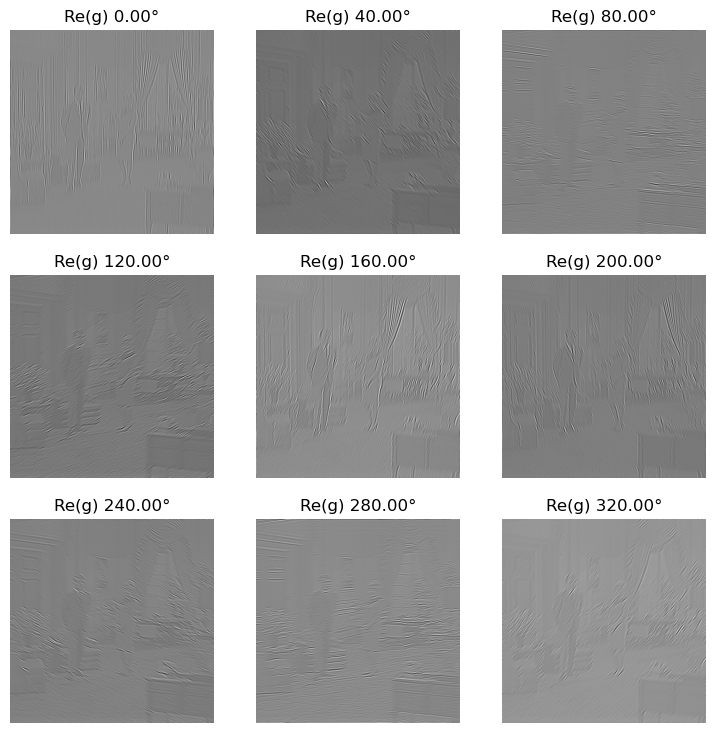

In [17]:
n_angles = 9
image = lroom
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Lake

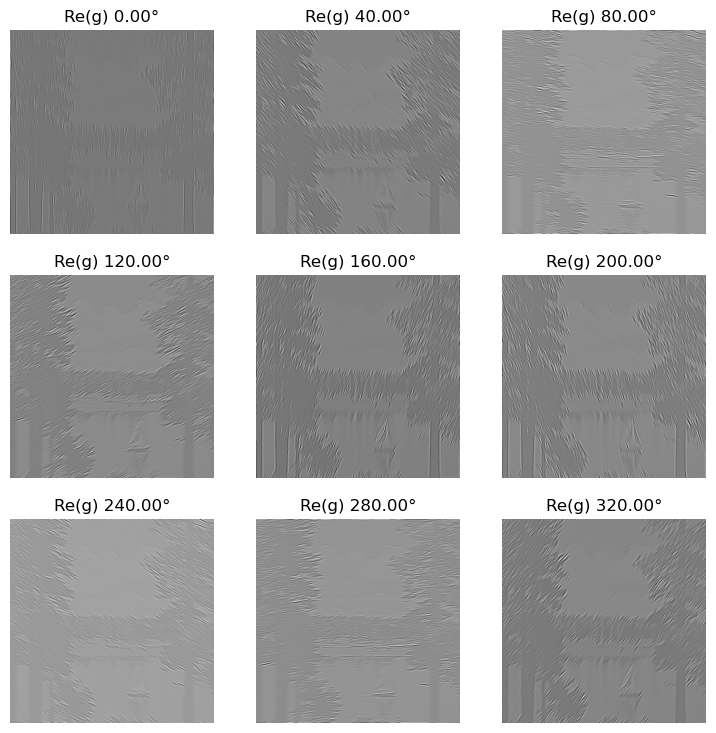

In [18]:
n_angles = 9
image = lake
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, False, image)

### Parte Real X Parte Imaginária

Os filtros de gabor causam efeitos ligeiramente diferentes na amplitude e na fase da imagem.

(-0.5, 255.5, 255.5, -0.5)

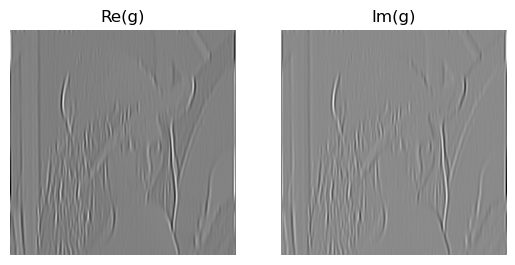

In [19]:
image = lena
shape = image.shape

filter = gabor_filter(shape, 0.0, sigma, gamma, lamb, phi)

img_filtered = apply_filter(image, filter)


plt.subplot(121)
plt.title("Re(g)")
plt.imshow(img_filtered.real, cmap = "gray")
plt.axis("off")

plt.subplot(122)
plt.title("Im(g)")
plt.imshow(img_filtered.imag, cmap = "gray")
plt.axis("off")

Apesar de não ser inicialmente perceptível a "olho nu", o efeito é melhor percebido quando se aplicam filtros de ângulos diferentes e se realiza uma média de todos os resultados:

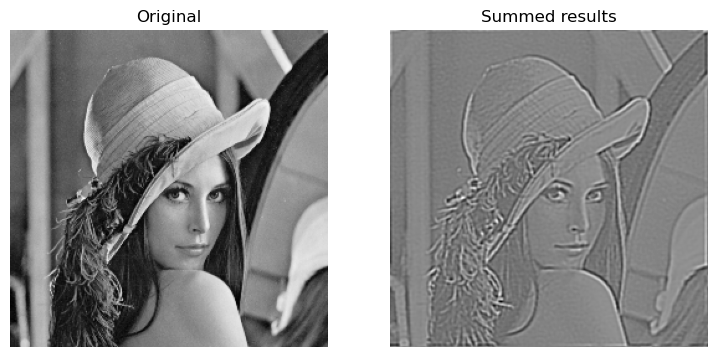

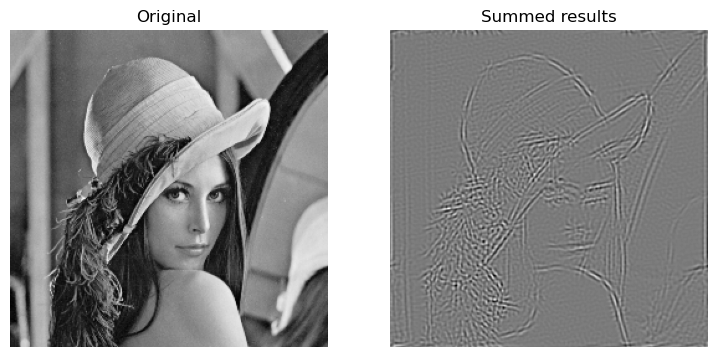

In [20]:
n_angles = 9
image = lena
shape = image.shape
gabor_set = gabor_angle_set(shape, n_angles, sigma, gamma, lamb, phi)
features = apply_filter_set(image, gabor_set)

show_filtered(features, gabor_set.keys(), False, True, image)
show_filtered(features, gabor_set.keys(), True, True, image)

Percebe-se que a média da parte real se assemelhra muito mais à imagem, apesar de também conter informações sobre as bordas, enquanto a parte imaginária, correspondente à fase, contém uma quantidade de informação muito mais significativa sobre as bordas e suas direções.

### Variação de $\lambda$ 

Explora-se agora os efeitos da variação de parâmetros geradores dos Filtros de Gabor. Para as próximas análises, usou-se a seguinte iamgem:

(-0.5, 511.5, 511.5, -0.5)

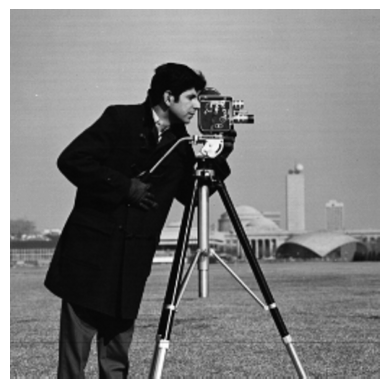

In [21]:
plt.imshow(cameraman, cmap = "gray")
plt.axis("off")

Iniciou-se com o comprimento de onda da parte senoidal, denotado por $\lambda$, na imagem alvo. $\lambda$ determina a largura de uma crista, ou seu inverso determina a velocidade com que a onda varia.

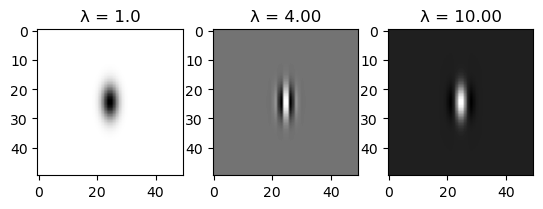

In [22]:
lamb1, lamb2, lamb3 = 1.0, 4.0, 10.0
shape1 = (50, 50)
gab1 = gabor_filter(shape1, 0.0, sigma, gamma, lamb1, phi)
gab2 = gabor_filter(shape1, 0.0, sigma, gamma, lamb2, phi)
gab3 = gabor_filter(shape1, 0.0, sigma, gamma, lamb3, phi)

plt.subplot(131)
plt.title(f"λ = {lamb1}")
plt.imshow(gab1.real, cmap = "gray")

plt.subplot(132)
plt.title(f"λ = " + "{:.2f}".format(lamb2))
plt.imshow(gab2.real, cmap = "gray")

plt.subplot(133)
plt.title(f"λ = " + "{:.2f}".format(lamb3))
plt.imshow(gab3.real, cmap = "gray")

Variando o $\lambda$:

In [23]:
lamb = np.arange(1.0, 10.0, 1.0)
phi = 0.0
sigma = 2.0
angle = 0.0
gamma = 0.5

Obtém-se:

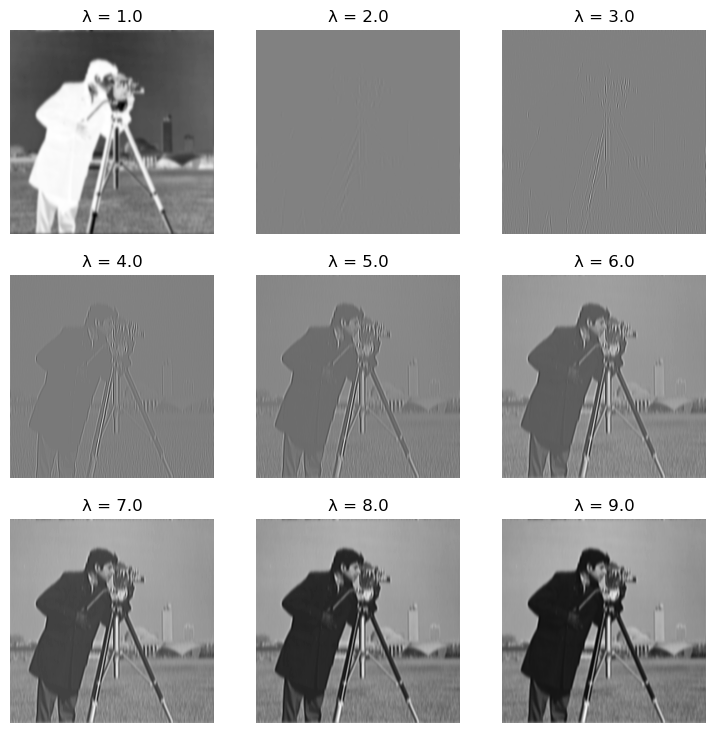

In [24]:
n_lamb = lamb.shape[0]

l1 = np.floor(np.sqrt(n_lamb))
l2 = np.ceil(n_lamb / l1)
img_size = 3.0

sub = l1*100 + l2*10 + 1

plt.figure(figsize = (l2*img_size, l1*img_size))
for i in range(n_lamb):
    plt.subplot(int(sub + i))
    filtered = apply_filter(cameraman, gabor_filter(cameraman.shape, angle, sigma, gamma, lamb[i], phi))
    plt.title(f"λ = {lamb[i]}")
    plt.imshow(filtered.real, cmap = "gray")
    plt.axis("off")
plt.show()

Verifica-se que, quanto maior o $\lambda$, menos a imagem sofrerá os efeitos do filtro, o que é explicado pois, com um lambda equilibrado, tanto a parte negativa quanto a parte positiva estarão incluídas dentro do envelope da gaussiana, o que irá permitir com que o efeito derivativo apareça, o que não ocorre com um lambda significativamente alto, como pode ser percebido pela imagem anterior.

### Variação de $\phi$

Explorou-se também os efeitos da variação de $\phi$, no caso, a fase da parte senoidal dos filtros. A fase, que pode variar no intervalo de $[0, 2\pi)$ apenas desloca a origem da onda.

In [25]:
lamb = 4.0
sigma = 2.0
angle = 0.0
gamma = 0.5

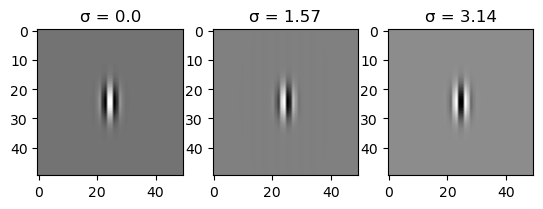

In [26]:
phi1, phi2, phi3 = 0.0, 2*np.pi/4.0, 2*np.pi/2.0
shape1 = (50, 50)
gab1 = gabor_filter(shape1, 0.0, sigma, gamma, lamb, phi1)
gab2 = gabor_filter(shape1, 0.0, sigma, gamma, lamb, phi2)
gab3 = gabor_filter(shape1, 0.0, sigma, gamma, lamb, phi3)

plt.subplot(131)
plt.title(f"σ = {phi1}")
plt.imshow(gab1.real, cmap = "gray")

plt.subplot(132)
plt.title(f"σ = " + "{:.2f}".format(phi2))
plt.imshow(gab2.real, cmap = "gray")

plt.subplot(133)
plt.title(f"σ = " + "{:.2f}".format(phi3))
plt.imshow(gab3.real, cmap = "gray")

Variando a fase:

In [27]:
lamb = 4.0
phis = np.arange(0.0, 2*np.pi, 2*np.pi/9.0)
sigma = 2.0
angle = 0.0
gamma = 0.5

Obtém-se:

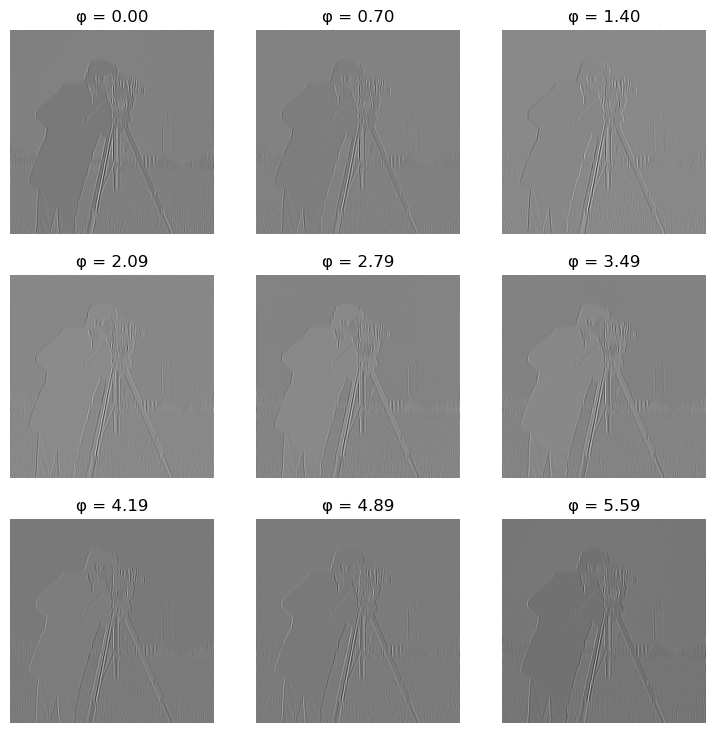

In [28]:
n_phi = phis.shape[0]

l1 = np.floor(np.sqrt(n_phi))
l2 = np.ceil(n_phi / l1)
img_size = 3.0

sub = l1*100 + l2*10 + 1

plt.figure(figsize = (l2*img_size, l1*img_size))
for i in range(n_phi):
    plt.subplot(int(sub + i))
    filtered = apply_filter(cameraman, gabor_filter(cameraman.shape, angle, sigma, gamma, lamb, phis[i]))
    plt.title(f"φ = " + "{:.2f}".format(phis[i]))
    plt.imshow(filtered.real, cmap = "gray")
    plt.axis("off")
plt.show()

Verificando-se uma alteração na identificação das bordas da imagem, a qual os valores de $1.4$ e $2.09$ parecem ter obtido mais sucesso na identificação "pura" de bordas.

### Variação de $\sigma$ 

Explorou-se também os efeitos da variação de $\sigma$, no caso, o desvio padrão da gaussiana. A variação do sigma afeta o largura da gaussiana, que ao se multiplicar com a parte senoidal, envelopa mais cristas.

In [29]:
lamb = 4.0
phi = 0.0
angle = 0.0
gamma = 0.5

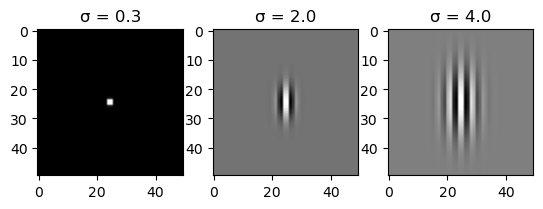

In [30]:
sigma1, sigma2, sigma3 = 0.3, 2.0, 4.0
shape1 = (50, 50)
gab1 = gabor_filter(shape1, 0.0, sigma1, gamma, lamb, phi)
gab2 = gabor_filter(shape1, 0.0, sigma2, gamma, lamb, phi)
gab3 = gabor_filter(shape1, 0.0, sigma3, gamma, lamb, phi)


plt.subplot(131)
plt.title(f"σ = {sigma1}")
plt.imshow(gab1.real, cmap = "gray")

plt.subplot(132)
plt.title(f"σ = {sigma2}")
plt.imshow(gab2.real, cmap = "gray")

plt.subplot(133)
plt.title(f"σ = {sigma3}")
plt.imshow(gab3.real, cmap = "gray")

Variando-se $\sigma$:

In [31]:
lamb = 4.0
phi = 0.0
sigmas = np.arange(1.0, 10.0, 1.0)
angle = 0.0
gamma = 0.5

Obtém-se:

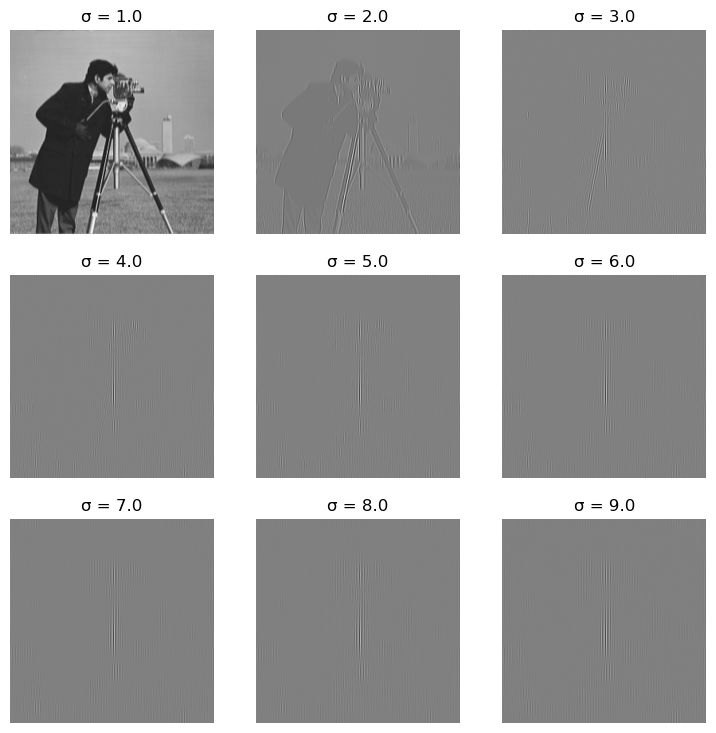

In [32]:
n_sigma = sigmas.shape[0]

l1 = np.floor(np.sqrt(n_sigma))
l2 = np.ceil(n_sigma / l1)
img_size = 3.0

sub = l1*100 + l2*10 + 1

plt.figure(figsize = (l2*img_size, l1*img_size))
for i in range(n_sigma):
    plt.subplot(int(sub + i))
    filtered = apply_filter(cameraman, gabor_filter(cameraman.shape, angle, sigmas[i], gamma, lamb, phi))
    plt.title(f"σ = {sigmas[i]}")
    plt.imshow(filtered.real, cmap = "gray")
    plt.axis("off")
plt.show()

Verifica-se que, quanto maior o sigma, maior será o efeito de aparecimento de cristas em regiões as quais identifica-se uma variação de valor, provocando o quase total desaparecimento da imagem.

### Variação de $\gamma$

Por último, explorou-se a variação de $\gamma$. A variação de $\gamma$ provoca um efeito de "esticamento" da parte gaussiana, a qual valores entre 0.0 e 1.0 provocam um esticamento na direção de $y'$ (é importante notar que o esticamento é na direção do eixo rotacionado), enquanto valores acima de 1.0 provocam o mesmo efeito, porém em $x'$.

In [33]:
lamb = 4.0
phis = 0.0
sigma = 2.0
angle = 0.0

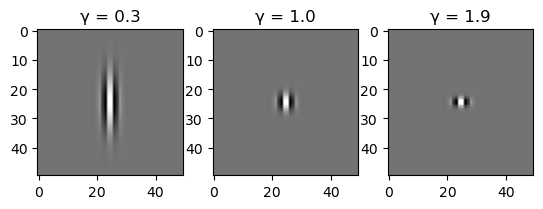

In [34]:
gamma1, gamma2, gamma3 = 0.3, 1.0, 1.9
shape1 = (50, 50)
gab1 = gabor_filter(shape1, 0.0, sigma, gamma1, lamb, phi)
gab2 = gabor_filter(shape1, 0.0, sigma, gamma2, lamb, phi)
gab3 = gabor_filter(shape1, 0.0, sigma, gamma3, lamb, phi)


plt.subplot(131)
plt.title(f"γ = {gamma1}")
plt.imshow(gab1.real, cmap = "gray")

plt.subplot(132)
plt.title(f"γ = {gamma2}")
plt.imshow(gab2.real, cmap = "gray")

plt.subplot(133)
plt.title(f"γ = {gamma3}")
plt.imshow(gab3.real, cmap = "gray")

Aplicando, para os seguintes parâmetros, uma variação em $\gamma$:

In [35]:
lamb = 4.0
phis = 0.0
sigma = 2.0
angle = 0.0
gammas = np.arange(0.1, 2.0 + 0.1, 2.0/9.0)

Obtém-se:

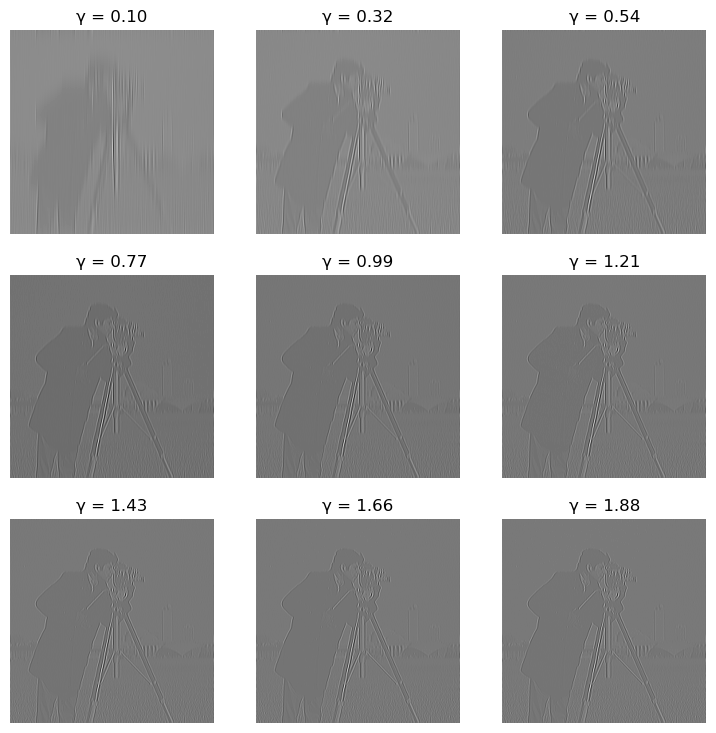

In [36]:
n_gamma = gammas.shape[0]

l1 = np.floor(np.sqrt(n_gamma))
l2 = np.ceil(n_gamma / l1)
img_size = 3.0

sub = l1*100 + l2*10 + 1

plt.figure(figsize = (l2*img_size, l1*img_size))
for i in range(n_gamma):
    plt.subplot(int(sub + i))
    filtered = apply_filter(cameraman, gabor_filter(cameraman.shape, angle, sigma, gammas[i], lamb, phi))
    plt.title(f"γ = " + "{:.2f}".format(gammas[i]))
    plt.imshow(filtered.real, cmap = "gray")
    plt.axis("off")
plt.show()

O efeito resultante desse "esticamento" na direção do eixo perpendicular à frente de onda da parte senoidal causa uma espécie de borramento direcional, ou como conhecido popularmente, "motion blur". Na direção paralela à frente de onda, não parece causar nenhum efeito significativo.

## Conclusão

Como verificado anteriormente, os Filtros de Gabor constituem uma poderosa ferramenta de extração de características de imagens. Seus cinco parâmetros, com a possibilidade de assumirem valores em um intervalo significativo, dão origem a um completo banco de filtros, cada qual podendo ter uma aplicação em um contexto diferente, para imagens diferentes.

Por conta de sua capacidade de identificação de bordas, seu uso para extração de características morfológicas de elementos em imagens pode ser útil para uma área em especial: a de Inteligência Artificial. Ao usar um conjunto de filtros para pré-processar uma imagem, os elementos resultantes podem caracterizar uma "assinatura" dos objetos presentes na imagem, seja a parte real, imaginária, ou algum dado derivado desses resultados, se tornando vetores de características a serem usados como entrada para redes neurais convolucionais, ou algum outro modelo de IA que se beneficie desse tipo de vetores de entrada.

Atualmente, alguns exemplos sobre como Filtros de Gabor podem ser usados por IAs de reconhecimento incluem reconhecimento de íris [4], reconhecimento de rostos [5], extração de caraceterísticas em imagens de ressonância magnética [6], reconhecimento de digitais [7], além de alguns outros exemplos.

É importante ressaltar que esse método tem sim suas limitações. A geração de um significativamente grande banco de filtros a partir das 5 variáveis é uma via de mão dupla: enquanto essa flexibilidade pode indicar uma boa adaptabilidade e flexibilidade dos filtros, também representa uma dificuldade de encontrar sob quais condições quais valores dos parâmetros funcionam melhor. De qualquer maneira, seu potencial é significativo, visto a grande quantidade de aplicações atualmente que os utilizam.

## Referências

1. Gabor, D. (1946). "Theory of communication". J. Inst. Electr. Eng. 93.
2. Granlund G. H. (1978). "In Search of a General Picture Processing Operator". Computer Graphics and Image Processing. 8 (2): 155–173. doi:10.1016/0146-664X(78)90047-3. ISSN 0146-664X.
3. Li, Bing; Babu, G. Jogesh (2019), "Convolution Theorem and Asymptotic Efficiency", A Graduate Course on Statistical Inference, New York: Springer, pp. 295–327, ISBN 978-1-4939-9759-6
4. M. Danlami, S. Jamel, S. N. Ramli and S. R. M. Azahari, "Comparing the Legendre Wavelet filter and the Gabor Wavelet filter For Feature Extraction based on Iris Recognition System," 2020 IEEE 6th International Conference on Optimization and Applications (ICOA), Beni Mellal, Morocco, 2020, pp. 1-6, doi: 10.1109/ICOA49421.2020.9094465.
5. R. R. Isnanto, A. A. Zahra, A. L. Kurniawan and I. P. Windasari, "Face Recognition System Using Feature Extraction Method of 2-D Gabor Wavelet Filter Bank and Distance-Based Similarity Measures," 2022 Seventh International Conference on Informatics and Computing (ICIC), Denpasar, Bali, Indonesia, 2022, pp. 1-4, doi: 10.1109/ICIC56845.2022.10007016. 
6. P. K. Padiyar and A. D. Rahulkar, "Design of Adaptive Gabor Filter Bank for Feature Extraction of MRI Images and Classification using Support Vector Machine," 2023 IEEE International Conference on Electronics, Computing and Communication Technologies (CONECCT), Bangalore, India, 2023, pp. 1-5, doi: 10.1109/CONECCT57959.2023.10234741. 
7. V. K. Singh, K. J. Mathai and S. Singh, "Fingerprint Segmentation: Optimization of a Filtering Technique with Gabor Filter," 2014 Fourth International Conference on Communication Systems and Network Technologies, Bhopal, India, 2014, pp. 823-827, doi: 10.1109/CSNT.2014.171. 







